In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import ccdproc
import photutils

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from mmtwfs.wfs import wfs_norm
from skycam_utils.photometry import make_background, make_segmentation_image

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
%cd /Users/tim/MMT/sky_brightness/asi_skycam/Bias/

/Volumes/LaCie 8TB/sky_brightness/asi_skycam/Bias


In [ ]:
biases = ccdproc.ImageFileCollection('.', keywords="*", glob_include="Bias*")

In [ ]:
for h in biases.hdus(save_location='reduced', overwrite=True, ccd_kwargs={'unit': 'adu', 'gain': 1.0}):
    h.header['fixscale'] = True
    h.data = h.data / 16

In [ ]:
scaled_biases = ccdproc.ImageFileCollection('./reduced', keywords="*", glob_include="Bias_*")

In [ ]:
bias = ccdproc.combine(
    list(scaled_biases.ccds(ccd_kwargs={'unit': 'adu'})),
    method='average',
    mem_limit=1e9,
    clip_extreme=True,
    nlow=2,
    nhigh=2,
    dtype=np.float64
)
bias.write("./bias.fits", overwrite=True)

In [5]:
%cd ../Light

/Volumes/LaCie 8TB/sky_brightness/asi_skycam/Light


In [ ]:
filters = ['clear', 'u', 'g', 'r', 'i']
#filters = ['u']
for f in filters:
    rpath = f"{f}/reduced"
    if not Path.exists(Path(rpath)):
        Path.mkdir(Path(rpath))
    ic = ccdproc.ImageFileCollection(f"./{f}", keywords="*", glob_include="Light_*")
    for h in ic.hdus(save_location=rpath, overwrite=True, ccd_kwargs={'unit': u.adu, 'gain': 1.0}):
        h.header['fixscale'] = True
        h.data = h.data / 16
        h.data = h.data - bias.data

In [14]:
test_im = CCDData.read(Path("./r/reduced/Light_024.fits"), unit=u.adu, gain=1.0)
test_im.header['GAIN'] = 1.0

In [ ]:
sigma = 3.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
threshold = photutils.detect_threshold(test_im.data, snr=5.)
segm = photutils.detect_sources(test_im.data, threshold, npixels=npixels, filter_kernel=kernel)
segm.remove_border_labels(border_width=10)
#segm = photutils.deblend_sources(test_im.data, segm_raw, npixels=npixels, filter_kernel=kernel, nlevels=32, contrast=0.001)

In [ ]:
plt.imshow(segm, cmap=segm.cmap(random_state=12345))
plt.show()

In [12]:
bkg = make_background(test_im.data, boxsize=(7, 7), filter_size=(5, 5))

<IPython.core.display.Javascript object>


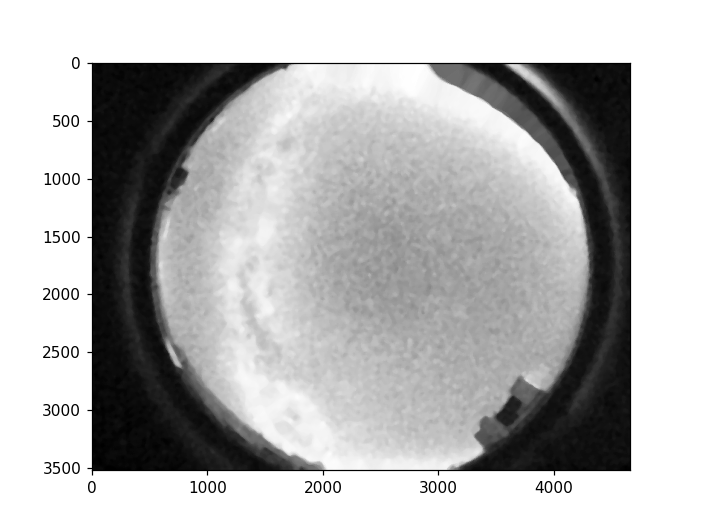

In [13]:
plt.imshow(bkg.background, cmap='Greys_r', norm=wfs_norm(bkg.background))
plt.show()

In [ ]:
fits.writeto('bkg.fits', bkg.background, overwrite=True)

In [ ]:
diff = test_im.data - bkg.background
fits.writeto('diff.fits', diff, overwrite=True)

In [ ]:
xmid = int(diff.shape[1]/2)
ymid = int(diff.shape[0]/2)
xl = xmid - 900
xu = xmid + 900
yl = ymid - 900
yu = ymid + 900
fits.writeto("diff_trim.fits", diff[yl:yu,xl:xu], overwrite=True)

In [ ]:
0.0373412253334 * 3600

In [ ]:
diff_trim_hdul = fits.open("diff_trim.new")
diff_trim = diff_trim_hdul[0].data
w = WCS(diff_trim_hdul[0])

In [ ]:
sigma = 2.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()
npixels = 7
threshold = photutils.detect_threshold(diff_trim, snr=5.)
segm_raw = photutils.detect_sources(diff_trim, threshold, npixels=npixels, filter_kernel=kernel)
segm_trim = photutils.deblend_sources(diff_trim, segm_raw, npixels=npixels, filter_kernel=kernel, nlevels=32, contrast=0.001)

In [ ]:
plt.imshow(segm_trim, cmap=segm.cmap(random_state=12345))
plt.show()

In [ ]:
cat_trim = photutils.source_properties(diff_trim, segm_trim, wcs=w)

In [ ]:
t_trim = cat_trim.to_table()
t_trim.write("diff_trim_cat.csv", overwrite=True)

In [ ]:
phot_cat = Table.read("bright_star_sloan.fits")

In [ ]:
t_trim[0]['sky_centroid_icrs']

In [ ]:
phot_cat['coords'] = SkyCoord(phot_cat['_RAJ2000'], phot_cat['_DEJ2000'], frame='icrs', unit='deg')

In [ ]:
idx, d2d, d3d = t_trim['sky_centroid_icrs'].match_to_catalog_sky(phot_cat['coords'])

In [ ]:
max_sep = 10. * u.arcmin
sep_constraint = d2d < max_sep
c_matches = t_trim[sep_constraint]
phot_matches = phot_cat[idx[sep_constraint]]

In [ ]:
phot_matches

In [ ]:
c_matches['obs_mag'] = -2.5 * np.log10(c_matches['source_sum'])
phot_off = phot_matches['r_mag'] - c_matches['obs_mag']
cut = phot_matches['r_mag'] < 3.5
plt.scatter(phot_matches['r_mag'][cut], phot_off[cut])
#plt.scatter(phot_matches['r_mag'], c_matches['obs_mag'])
plt.show()

In [ ]:
r_zp = phot_off[cut].mean()

In [ ]:
sky_mag = r_zp + (-2.5 * np.log10(11.2/137.**2))
sky_mag

In [ ]:
c_matches.columns

In [ ]:
plt.scatter(phot_matches['r_mag'], c_matches['max_value'])
plt.show()

In [ ]:
t_trim.show_in_notebook()

In [15]:
type(Path("diff_trim.new"))

pathlib.PosixPath